In [11]:
import os 
import numpy as np 
import pandas as pd 
import copy
import desc
import matplotlib.pyplot as pl
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error

In [12]:
import anndata
import scanpy as sc

In [13]:
from importlib import reload
import GE_functions
reload(GE_functions)

<module 'GE_functions' from '/data/jlu/Chaperone_Analysis/GE_functions.py'>

Now that we have compared the gene lists between two different processes of single cell data. Make a new list of genes consisting of the join of top X number of genes from both nomralized/processed as a gene_list. The goal is to then see if either of these genes are also highly expressed in the mOSNs. 

Once the genes are obtained. We can then filter the genes by comparing the list to other different cell types in in the OE. 

Lastly, filter the gene_list by pan neuron markers. (So that the identified chaperone is truly co-expressed with Rtp1 instead of just present in all neurons).

Get top X number of genes from all the other cell types in brann

In [23]:
adata_brann = anndata.read_csv('./files/Brann/GSE151346_MOE_all_counts.csv')
meta_data = pd.read_table('./files/Brann/GSE151346_MOE_metadata.tsv')
meta_data = meta_data.set_index('index')
# transpose used to flip obs and vars.
adata_brann = adata_brann.copy().transpose()

In [24]:
adata_brann.raw = adata_brann

In [25]:
# Subset the adata by only cells included in metadata. Attach meta info onto adata
adata_brann = adata_brann[meta_data.index, :]
adata_brann.obs = adata_brann.obs.join(meta_data).dropna(axis = 0)

In [17]:
# # convert anndata to pandas in order to manipulate count matrix 
# pd_adata = pd.DataFrame(data=adata_brann.X, 
#                         index=adata_brann.obs_names, 
#                         columns=adata_brann.var_names)
# # Concatenating all Olfr genes into a Olfr_sum as gene name
# pd_Olfr = pd_adata[pd_adata.columns[pd_adata.columns.str.match('Olfr')]]
# pd_adata = pd_adata[pd_adata.columns[np.invert(pd_adata.columns.str.match('Olfr'))]]
# pd_adata['Olfr_sum'] = pd_Olfr.sum(1)
# matrix = np.matrix(pd_adata)
# # Reconstruct adata from pandas df 
# obs = pd.DataFrame(index=pd_adata.index)
# var = pd.DataFrame(index=pd_adata.columns)
# adata_brann = anndata.AnnData(matrix, obs=obs, var=var)
# # add meta data back again and save raw
# adata_brann.obs = adata_brann.obs.join(meta_data).dropna(axis = 0)
# adata_brann.raw = adata_brann

In [26]:
sc.pp.normalize_per_cell(adata_brann, counts_per_cell_after=1e4)
sc.pp.log1p(adata_brann)

In [27]:
adata_brann.var['mt'] = adata_brann.var_names.str.startswith('Mt') 
sc.pp.calculate_qc_metrics(adata_brann, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# Define genes to be removed from the datasets prior to finding highly variable genes for clustering
mito_genes = adata_brann.var_names.str.startswith('mt-')
malat1 = adata_brann.var_names.str.startswith('Malat')
remove = np.add(mito_genes, malat1)
keep = np.invert(remove)
adata_brann = adata_brann[:,keep]

In [28]:
# computer and filter data by highly_variabel_genes
sc.pp.highly_variable_genes(adata_brann, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_brann = adata_brann[:, adata_brann.var.highly_variable]
# regress out total counts and mt pct 
sc.pp.regress_out(adata_brann, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_brann, max_value=10)
# calculate pca 
sc.tl.pca(adata_brann, svd_solver='arpack')
sc.pp.neighbors(adata_brann, n_neighbors=10, n_pcs=40)
sc.tl.draw_graph(adata_brann)
# calculate umap 
sc.tl.umap(adata_brann)

Trying to set attribute `._uns` of view, copying.
/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'orig_ident' as categorical
/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories),

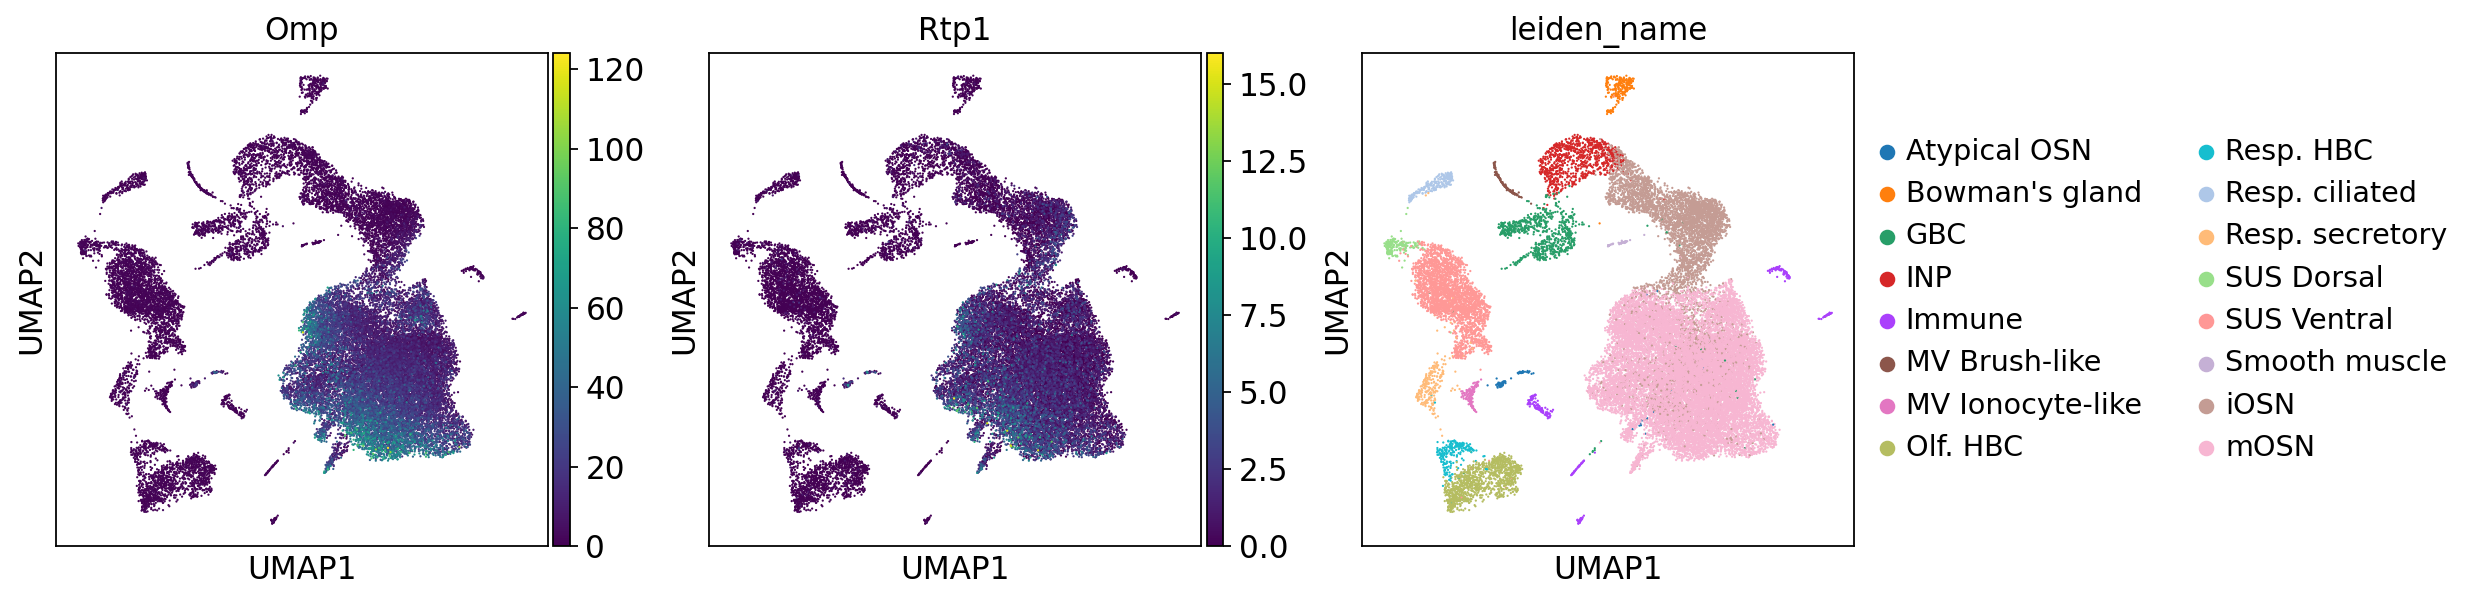

In [29]:
sc.set_figure_params(facecolor='White')
sc.pl.umap(adata_brann, color=['Omp','Rtp1','leiden_name'])

In [30]:
gene_names = GE_functions.get_gene_names(adata_brann)
adata_brann[:,gene_names].var

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
1700001C02Rik,False,141,0.009222,99.523407,272.830475,True,0.034637,2.520293,0.614226,2.107107e-11,0.139223
1700011I03Rik,False,68,0.004111,99.770154,121.621445,True,0.014240,2.534812,0.634986,-2.929289e-12,0.089617
1700024G13Rik,False,314,0.023840,98.938651,705.312866,True,0.112296,3.011761,1.316925,1.695700e-11,0.240499
2310003N18Rik,False,89,0.005933,99.699172,175.538773,True,0.023014,2.484849,0.563550,1.444124e-11,0.113170
2810474O19Rik,False,3394,0.233164,88.527970,6898.143066,True,0.675318,2.610395,0.861111,2.392446e-11,0.675588
...,...,...,...,...,...,...,...,...,...,...,...
Olfr639,False,23,0.002346,99.922258,69.409889,True,0.021788,3.874629,2.550649,-6.129290e-12,0.087644
Olfr658,False,15,0.001780,99.949299,52.659264,True,0.021674,4.100827,2.874066,-1.418351e-11,0.081232
Olfr822,False,18,0.001763,99.939158,52.153118,True,0.034669,5.087564,4.284898,-3.030153e-12,0.081526
Olfr906,False,8,0.000852,99.972959,25.206253,True,0.014022,4.663440,3.678487,2.507626e-12,0.057532


In [31]:
sc.tl.rank_genes_groups(adata_brann, 'leiden_name', method='wilcoxon')
cell_top_markers = pd.DataFrame(adata_brann.uns['rank_genes_groups']['names'])

/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


In [ ]:
# Plotting the provided UMAP coordinates on metafile to visualize 
fig = px.scatter(adata_brann.obs, x='UMAP_1', y= 'UMAP_2', color='leiden_name')
fig.update_traces(marker = dict(size = 3, opacity = 0.5))
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    })
fig.show()

In [35]:
cell_top_markers.to_csv('./output/brann/CELL_top_markers_include_Rik_GMgenes.csv')

Take top X numbers of genes from both columns of the table and defined as top genes for the given cell types 

In [43]:
# cell_top_markers = pd.read_csv('./output/brann/CELL_top_markers.csv', index_col=[0])
Rank_genes_table_rtp1 = pd.read_csv('./expression_csv/mse_normalized_rtp1_GSE151346_MOE_ALL_OlfrSeperated_include_Rik_GMgenes.csv', index_col=[0])

First transform the cell_top_marker table into a rank table

In [46]:
# transforms cell_top_markers table into ranks matching the rank_genes_table
cell_genes_rank = pd.DataFrame(index = Rank_genes_table_rtp1.columns)
for column in cell_top_markers.columns:
    temp = cell_top_markers[[column]].set_index(column)
    temp = temp[temp.index.isin(cell_genes_rank.index)]
#     temp[column] = range(len(temp),0,-1) 
    temp[column] = range(0,len(temp)) 
    cell_genes_rank = cell_genes_rank.join(temp)

In [48]:
# Drop OSN like columns. 
# cell_genes_rank = cell_genes_rank.drop(columns=['iOSN','mOSN','GBC','INP','Atypical OSN'])
cell_genes_rank.to_csv('./output/brann/CELL_genes_rank_include_Rik_GMgenes.csv')
# cell_genes_rank.to_csv('./output/brann/CELL_genes_rank_reversed.csv')
# cell_genes_rank = pd.read_csv('./output/brann/CELL_genes_rank_reversed.csv', index_col=[0])

Now that we have a rank table of all the HVG reversed in order for other cell types. Find pan-neuronal markers from the Brann OB dataset. 

In [62]:
OB_adata = anndata.read_csv('./files/GSE148360_OB_2016Dec_all_counts.csv')

In [63]:
Datta_meta = pd.read_csv('./files/GSE148360_Datta_integratedOB_UMAP_noDoublets.csv', index_col=[0])
Linnarson_meta = pd.read_csv('./files/GSE148360_Linnarsson_integratedOB_UMAP_noDoublets.csv', index_col=[0])
meta = pd.concat([Datta_meta,Linnarson_meta])

In [64]:
OB_adataata= OB_adata.copy()

In [65]:
OB_adata = OB_adata.transpose()
OB_adata.obs = OB_adata.obs.join(meta)
OB_adata = OB_adata[OB_adata.obs.dropna(axis='rows').index]

In [66]:
fig = px.scatter(OB_adata.obs, x='UMAP_1', y= 'UMAP_2', color='Cell_class')
fig.update_traces(marker = dict(size = 3, opacity = 0.5))
fig.show()

In [67]:
# convert anndata to pandas in order to manipulate count matrix 
pd_adata = pd.DataFrame(data=OB_adata.X, 
                        index=OB_adata.obs_names, 
                        columns=OB_adata.var_names)
# Concatenating all Olfr genes into a Olfr_sum as gene name
pd_Olfr = pd_adata[pd_adata.columns[pd_adata.columns.str.match('Olfr')]]
pd_adata = pd_adata[pd_adata.columns[np.invert(pd_adata.columns.str.match('Olfr'))]]
pd_adata['Olfr_sum'] = pd_Olfr.sum(1)
matrix = np.matrix(pd_adata)
# Reconstruct adata from pandas df 
obs = pd.DataFrame(index=pd_adata.index)
var = pd.DataFrame(index=pd_adata.columns)
OB_adata = anndata.AnnData(matrix, obs=obs, var=var)
# add meta data back again and save raw
OB_adata.obs = OB_adata.obs.join(meta).dropna(axis = 0)
OB_adata.raw = OB_adata

In [68]:
sc.pp.normalize_per_cell(OB_adata, counts_per_cell_after=1e4)
sc.pp.log1p(OB_adata)

In [69]:
OB_adata.var['mt'] = OB_adata.var_names.str.startswith('Mt') 
sc.pp.calculate_qc_metrics(OB_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# Define genes to be removed from the datasets prior to finding highly variable genes for clustering
mito_genes = OB_adata.var_names.str.startswith('mt-')
malat1 = OB_adata.var_names.str.startswith('Malat')
remove = np.add(mito_genes, malat1)
keep = np.invert(remove)
OB_adata = OB_adata[:,keep]

In [70]:
# computer and filter data by highly_variabel_genes
sc.pp.highly_variable_genes(OB_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
OB_adata = OB_adata[:, OB_adata.var.highly_variable]
# regress out total counts and mt pct 
sc.pp.regress_out(OB_adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(OB_adata, max_value=10)
# calculate pca 
sc.tl.pca(OB_adata, svd_solver='arpack')
sc.pp.neighbors(OB_adata, n_neighbors=10, n_pcs=40)
sc.tl.draw_graph(OB_adata)
# calculate umap 
sc.tl.umap(OB_adata)

Trying to set attribute `._uns` of view, copying.
/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning:

The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.

/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning:

Initializing view as actual.

Trying to set attribute `.obs` of view, copying.
... storing 'Cell_class' as categorical


In [71]:
gene_names = GE_functions.get_gene_names(OB_adata)
OB_adata[:,gene_names].var

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
A2m,False,84,0.005996,99.688935,161.920013,True,0.022204,2.370150,0.544130,-4.775030e-12,0.112203
A3galt2,False,52,0.004221,99.807436,113.996338,True,0.018648,2.688981,1.127572,-2.629734e-12,0.099820
Aacs,False,450,0.032965,98.333580,890.180603,True,0.119478,2.425276,0.645007,-1.651990e-11,0.264418
Aard,False,74,0.005732,99.725967,154.787628,True,0.022926,2.471785,0.730117,9.492910e-12,0.113304
Aars2,False,464,0.033836,98.281736,913.703491,True,0.120355,2.374537,0.552158,8.575521e-11,0.266401
...,...,...,...,...,...,...,...,...,...,...,...
Zxdc,False,619,0.047268,97.707747,1276.416138,True,0.174507,2.485490,0.755195,-1.986527e-11,0.320874
Camp,False,8,0.000936,99.970375,25.288761,True,0.045557,6.370409,7.864372,7.092111e-13,0.064073
Igkc,False,12,0.001569,99.955562,42.360748,True,0.029732,5.091652,5.524322,-1.976672e-12,0.078793
Ngp,False,5,0.000726,99.981484,19.614674,True,0.045168,6.521032,8.140004,-1.050811e-11,0.060194


In [73]:
sc.tl.rank_genes_groups(OB_adata, 'Cell_class', method='wilcoxon')
Neuron_top_markers = pd.DataFrame(OB_adata.uns['rank_genes_groups']['names'])

In [75]:
gene_names = pd.read_csv('./output/brann/CELL_genes_rank.csv', index_col=[0]).index

In [77]:
Neuron_genes_rank = GE_functions.gene_to_rank(Neuron_top_markers, gene_names)
Neuron_genes_rank.to_csv('./output/brann/NEURON_genes_rank_reversed.csv')
Neuron_genes_rank = GE_functions.gene_to_rank(Neuron_top_markers, gene_names, reverse_rank=False)
Neuron_genes_rank.to_csv('./output/brann/NEURON_genes_rank.csv')